In [2]:
#Librerias
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp 
#Utilizando scipy.io.loadmat leeré el archivo .mat
import scipy.io
import scipy.special as sps

canal = scipy.io.loadmat('canal.mat')
#Obteniendo la información del archivo .mat
#Quiero mi canal contenga la matriz de 1000x1000, por lo que utilizo debería eliminar lo demás
canal = canal['h0']
print(canal)


[[-0.11951302-0.03002565j -0.16633978-0.00378771j -0.20590646+0.03213096j
  ... -0.19266062-0.6909949j  -0.21929658-0.63927758j
  -0.24041227-0.59043801j]
 [-0.03227397-0.11604732j -0.07289313-0.08553665j -0.10798474-0.04587161j
  ... -0.27433318-0.79229858j -0.2975771 -0.74936408j
  -0.31427334-0.70752099j]
 [ 0.05097152-0.20715541j  0.01819219-0.17273322j -0.01079388-0.1297282j
  ... -0.34950825-0.85936944j -0.36946363-0.82554283j
  -0.38176973-0.79115839j]
 ...
 [ 0.26557285-0.82462525j  0.25919041-0.66350866j  0.25071603-0.48344438j
  ... -0.46880894+0.37586773j -0.3880489 +0.35138115j
  -0.28792032+0.31384223j]
 [ 0.1557032 -0.86744126j  0.16295033-0.69818314j  0.16837287-0.51024067j
  ... -0.34523119+0.48535255j -0.27032878+0.44825267j
  -0.17497769+0.39921806j]
 [ 0.03876507-0.89480163j  0.06148464-0.72109286j  0.08263439-0.52904432j
  ... -0.22835214+0.58590311j -0.16147773+0.5374104j
  -0.07297877+0.47820619j]]


”canal.mat” contiene una matriz de 1000 × 1000 puntos cada uno de los cuales representa la respuesta h0 (flat fading) de un canal inalambrico para distintos puntos de un mapa geografico cartesiano. La distancia entre puntos contiguos es de 1 cm.

In [4]:
SNR = 20
Eb = 1  # energia de bit
N0 = Eb / SNR

#Generando la secuencia de bits aleatorios

#Con una semilla, porque quiero que sea reproducible
# np.random.seed(0)

Nsimbol = 1000                  #Número de símbolos a transmitir
N = 1000                        #Número de muestras del canal
bits = np.random.randint(0,2,Nsimbol)
#Quiero tener 1 y -1, entonces a los 0 los cambio por -1
bits[bits==0] = -1
#Generando la secuencia de simbolos BPSK, con una potencia de sqrt(Eb)
simbolos = np.sign(bits)*np.sqrt(Eb)
#Al tener flat fading y al concocer perfectamente h0

multiplicacion = np.zeros(N, dtype=complex)
#Quiero ir moviendome por el canal de manera random para ir multiplicando por los simbolos
h0 = np.zeros(N, dtype=complex)

for i in range(N):
    indice1 = np.random.randint(0,1000)
    indice2 = np.random.randint(0,1000)
    multiplicacion[i] = canal[indice1,indice2]*simbolos[i]
    h0[i] = canal[indice1,indice2]

#Generando el ruido
wr = np.random.normal(0, np.sqrt(Eb / (2 * SNR)))
wi = np.random.normal(0, np.sqrt(Eb / (2 * SNR)))
w = wr + 1j * wi

y = multiplicacion + w*np.ones(N)                   #Señal recibida
r = np.real((np.conjugate(h0) / np.abs(h0)) * y)    #Estadistico suficiente

#Para calcular la probabilidad de error
#Si el r es menor a 0, entonces es -1, si es mayor a 0, entonces es 1
#Si el r es menor a 0 y el simbolo es 1, entonces es error
#Si el r es mayor a 0 y el simbolo es -1, entonces es error
Nro_errores = 0
x_estimado = np.zeros(Nsimbol)
for i in range(N):
    if r[i] < 0:
        x_estimado[i] = -1
        if simbolos[i] == 1:
            Nro_errores += 1
            print("Error en el simbolo ", i)
    elif r[i] > 0:
        x_estimado[i] = 1
        if simbolos[i] == -1:
            Nro_errores += 1
            print("Error en el simbolo ", i)
print("Fallaron un total de :",Nro_errores)


Error en el simbolo  99
Error en el simbolo  102
Error en el simbolo  123
Error en el simbolo  160
Error en el simbolo  219
Error en el simbolo  227
Error en el simbolo  329
Error en el simbolo  334
Error en el simbolo  355
Error en el simbolo  396
Error en el simbolo  428
Error en el simbolo  431
Error en el simbolo  458
Error en el simbolo  477
Error en el simbolo  505
Error en el simbolo  605
Error en el simbolo  609
Error en el simbolo  623
Error en el simbolo  625
Error en el simbolo  651
Error en el simbolo  692
Error en el simbolo  820
Error en el simbolo  829
Error en el simbolo  955
Error en el simbolo  997
Fallaron un total de : 25


Si cambio el randomseed o la SNR, cambiará el nro de fallos...

In [61]:
#Quiero saber el valor esperado de |canal|^2, para esto hallo |canal|^2 componente a componente
canal_cuadrado = np.zeros((1000,1000), dtype=complex)
for i in range(1000):
    for j in range(1000):
        canal_cuadrado[i,j] = np.abs(canal[i,j])**2

#Calculando el valor esperado de |canal|^2
valor_esperado = np.mean(canal_cuadrado)
print("El valor esperado de |canal|^2 es: ", valor_esperado)


El valor esperado de |canal|^2 es:  (1.0000000000000007+0j)


In [72]:
#Para realmente obtener la BER, se debe calcular un valor esperado
#Haré lo que hice arriba pero promediaré sobre realizaciones del canal(antes tenía sólo 1 realización)
SNR = 20
Eb = 1  # energia de bit
N0 = Eb / SNR
Nsimbol = 1000                  #Número de símbolos a transmitir
N = 1000                        #Número de muestras del canal
iteraciones = 1000
Errores = np.zeros(iteraciones)
for j in range(iteraciones):

    bits = np.random.randint(0,2,Nsimbol)
    bits[bits==0] = -1
    simbolos = np.sign(bits)*np.sqrt(Eb)
    multiplicacion = np.zeros(N, dtype=complex)
    h0 = np.zeros(N, dtype=complex)

    for i in range(N):
        indice1 = np.random.randint(0,1000)
        indice2 = np.random.randint(0,1000)
        multiplicacion[i] = canal[indice1,indice2]*simbolos[i]
        h0[i] = canal[indice1,indice2]

    wr = np.random.normal(0, np.sqrt(Eb / (2 * SNR)))
    wi = np.random.normal(0, np.sqrt(Eb / (2 * SNR)))
    w = wr + 1j * wi

    y = multiplicacion + w*np.ones(N)                   #Señal recibida
    r = np.real((np.conjugate(h0) / np.abs(h0)) * y)    #Estadistico suficiente

    x_estimado = np.zeros(Nsimbol)
    for i in range(N):
        if r[i] < 0:
            x_estimado[i] = -1
            if simbolos[i] == 1:
                Errores[j] += 1
        elif r[i] > 0:
            x_estimado[i] = 1
            if simbolos[i] == -1:
                Errores[j] += 1

BER = np.mean(Errores) / Nsimbol
print("La BER es: ", BER)



La BER es:  0.011301


La BER es:  0.011307000000000001

La BER es:  0.011301

Anda por ahí


### Desestimar los siguientes códigos, hasta que diga "Probabilidad de error teórica"

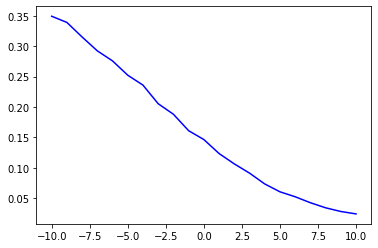

In [6]:
#Ahora lo haré para distintas SNR, para así poder trazar la curva de Perror vs SNR
SNR_dB_max = 20
SNR_dB_min = -10
SNR_dB_step = 1
SNR_dB = np.arange(SNR_dB_min, SNR_dB_max + SNR_dB_step, SNR_dB_step)
SNR = 10 ** (SNR_dB / 10)
Eb = 1  # energia de bit
N0 = Eb / SNR
BER = np.zeros(len(SNR))
Nsimbol = 1000                  #Número de símbolos a transmitir
N = 1000                        #Número de muestras del canal
iteraciones = 1000
for k in range(len(SNR)):
    Errores = np.zeros(iteraciones)
    for j in range(iteraciones):
        bits = np.random.randint(0,2,Nsimbol)
        bits[bits==0] = -1
        simbolos = np.sign(bits)*np.sqrt(Eb)
        multiplicacion = np.zeros(N, dtype=complex)
        h0 = np.zeros(N, dtype=complex)

        for i in range(N):
            indice1 = np.random.randint(0,N)
            indice2 = np.random.randint(0,N)
            multiplicacion[i] = canal[indice1,indice2]*simbolos[i]
            h0[i] = canal[indice1,indice2]

        wr = np.random.normal(0, np.sqrt(Eb / (2 * SNR[k])))
        wi = np.random.normal(0, np.sqrt(Eb / (2 * SNR[k])))
        w = wr + 1j * wi

        y = multiplicacion + w*np.ones(N)                   #Señal recibida
        r = np.real((np.conjugate(h0) / np.abs(h0)) * y)    #Estadistico suficiente

        x_estimado = np.zeros(Nsimbol)
        for i in range(N):
            if r[i] < 0:
                x_estimado[i] = -1
                if simbolos[i] == 1:
                    Errores[j] += 1
            elif r[i] > 0:
                x_estimado[i] = 1
                if simbolos[i] == -1:
                    Errores[j] += 1

    BER[k] = np.mean(Errores) / Nsimbol

plt.plot(SNR_dB, BER, 'b')

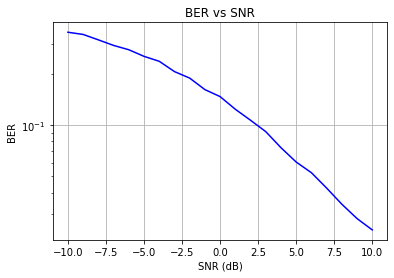

In [7]:
plt.plot(SNR_dB, BER, 'b')
plt.yscale('log')
plt.xlabel('SNR (dB)')
plt.ylabel('BER')
plt.title('BER vs SNR')
plt.grid()

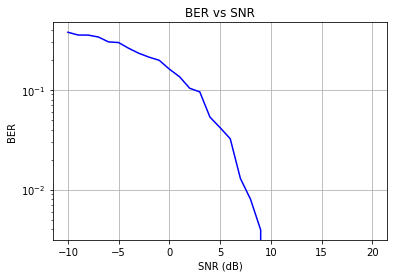

In [8]:
#El móvil receptor se mueva constantemente aprovechando el efecto Doppler para transmitir datos con un esquema BPSK 
PosRx_x = 0
PosRx_y = 500
Corrimiento_total = 50          #Centímetros
SNR_dB_max = 5
SNR_dB_min = -10
SNR_dB_step = 1
SNR_dB = np.arange(SNR_dB_min, SNR_dB_max + SNR_dB_step, SNR_dB_step)
SNR = 10 ** (SNR_dB / 10)
Eb = 1  # energia de bit
N0 = Eb / SNR
BER = np.zeros(len(SNR))
Nsimbol = 10000                  #Número de símbolos a transmitir
N = 1000                        #Número de muestras del canal
iteraciones = 100
for k in range(len(SNR)):
    for i in range(Corrimiento_total):
        Errores = np.zeros(iteraciones)
        for j in range(iteraciones):
            bits = np.random.randint(0,2,Nsimbol)
            bits[bits==0] = -1
            simbolos = np.sign(bits)*np.sqrt(Eb)
            multiplicacion = np.zeros(N, dtype=complex)
            h0 = canal[PosRx_x+i,PosRx_y]
            for p in range(Nsimbol):
                multiplicacion[p] = h0*simbolos[p]

            wr = np.random.normal(0, np.sqrt(Eb / (2 * SNR[k])))
            wi = np.random.normal(0, np.sqrt(Eb / (2 * SNR[k])))
            w = wr + 1j * wi

            y = multiplicacion + w*np.ones(N)                   #Señal recibida
            r = np.real((np.conjugate(h0) / np.abs(h0)) * y)    #Estadistico suficiente

            x_estimado = np.zeros(Nsimbol)
            for i in range(N):
                if r[i] < 0:
                    x_estimado[i] = -1
                    if simbolos[i] == 1:
                        Errores[j] += 1
                elif r[i] > 0:
                    x_estimado[i] = 1
                    if simbolos[i] == -1:
                        Errores[j] += 1

    BER[k] = np.mean(Errores) / Nsimbol

plt.plot(SNR_dB, BER, 'b')
plt.yscale('log')
plt.xlabel('SNR (dB)')
plt.ylabel('BER')
plt.title('BER vs SNR')
plt.grid()


## Probabilidad de error teórica

In [3]:
def Pe(SNR, L):
    mu = np.sqrt(SNR / (1 + SNR))
    m = []
    for l in range(L):
        m.append(sps.binom(L - 1 + l, l) * ((1 + mu) / 2) ** l)
    m = np.array(m)
    return ((1 - mu) / 2) ** L * np.sum(m, axis=0)

# DIVERSIDAD TEMPORAL

#### CASO L = 1, sin diversidad temporal

Código a omitir, primero pruebo con valores del canal random, y no está bien como estoy decidiendo x_estimado en este código.

In [ ]:
PosRx_x = 0
PosRx_y = 500
Corrimiento_total = 1000          #Centímetros
Corrimiento_step = 50
SNR_dB_max = 0
SNR_dB_min = -5
SNR_dB_step = 0.5
SNR_dB = np.arange(SNR_dB_min, SNR_dB_max + SNR_dB_step, SNR_dB_step)
SNR = 10 ** (SNR_dB / 10)
Eb = 1  # energia de bit
N0 = Eb / SNR
BER = np.zeros(len(SNR))
N = 1000                        #Número de muestras del canal
iteraciones = 50000
L = [1,2,3]                     #Diversidad temporal
a = 0                           #L[0] = 1
Nsimbol = 1                     #Número de símbolos a transmitir
Nsimbol = Nsimbol*L[a]          #Ahora el total de símbolos, teniendo en cuenta la repetición
for k in range(len(SNR)):
    for i in range(0,Corrimiento_total,Corrimiento_step):
        Errores = np.zeros(iteraciones)
        for j in range(iteraciones):
            bits = np.random.randint(0,2,int(Nsimbol/L[a]))
            bits_plus = bits
            #Busco que los bits se repetian 2 veces
            for t in range(L[a]-1):
                bits_plus = np.concatenate((bits_plus,bits))
            bits_plus[bits_plus==0] = -1
            simbolos = np.sign(bits_plus)*np.sqrt(Eb)
            
            multiplicacion = np.zeros(Nsimbol, dtype=complex)
            # h0 = canal[PosRx_x+i,PosRx_y]
            h0 = canal[np.random.randint(0,1000,1),np.random.randint(0,1000,1)]
            w = np.zeros(Nsimbol, dtype=complex)
            for p in range(Nsimbol):
                multiplicacion[p] = h0*simbolos[p]
                wr = np.random.normal(0, np.sqrt(Eb / (2*SNR[k])))
                wi = np.random.normal(0, np.sqrt(Eb / (2*SNR[k])))
                w[p] = wr + 1j * wi

            y = multiplicacion + w                                    #Señal recibida
            r = np.real((np.conjugate(h0) / np.abs(h0)) * y)          #Estadistico suficiente

            x_estimado = np.zeros(Nsimbol)
            for m in range(Nsimbol):
                if r[m] < 0:
                    x_estimado[m] = -1
                elif r[m] > 0:
                    x_estimado[m] = 1

            for m in range(int(Nsimbol/L[a])):
                contador_pos = 0
                contador_neg = 0
                for p in range(L[a]):
                    if(x_estimado[int(m+p*Nsimbol/L[a])] == 1):
                        contador_pos += 1
                    elif(x_estimado[int(m+p*Nsimbol/L[a])] == -1):
                        contador_neg += 1
                if(contador_pos > contador_neg):
                    x_estimado[m] = 1
                elif(contador_pos < contador_neg):
                    x_estimado[m] = -1
                #Sino me quedo con la primera repetición

            #Ahora trunco x_estimado
            x_estimado = x_estimado[0:int(Nsimbol/L[a])]
            #Ahora comparo con los bits originales
            for m in range(int(Nsimbol/L[a])):
                if x_estimado[m] != bits_plus[m]:
                    Errores[j] += 1
            

    BER[k] = np.mean(Errores) / Nsimbol

plt.plot(SNR_dB, BER, 'b')
plt.yscale('log')
plt.xlabel('SNR (dB)')
plt.ylabel('BER')
plt.title('BER vs SNR con L = 1')
plt.grid()
plt.plot(SNR_dB, Pe(SNR, L[a]), 'r')
plt.legend(['Simulación', 'Teórica'])
plt.show()

Mejor mirar el código de abajo directamente que empieza todo lo lindo, acá estaba probando a velocidad constante

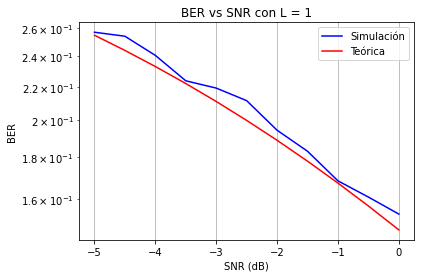

In [3]:
#El móvil receptor se mueva constantemente aprovechando el efecto Doppler para transmitir datos con un esquema BPSK 

iteraciones = 10000                         

Corrimiento_inicial = iteraciones*10                #Centímetros
Corrimiento_total = 1000000-Corrimiento_inicial          #Centímetros
Corrimiento_step = 1000                                      
SNR_dB_max = 0
SNR_dB_min = -5
SNR_dB_step = 0.5
SNR_dB = np.arange(SNR_dB_min, SNR_dB_max + SNR_dB_step, SNR_dB_step)
SNR = 10 ** (SNR_dB / 10)
Eb = 1  # energia de bit
N0 = Eb / SNR
BER = np.zeros(len(SNR))
L = [1,2,3]                     #Diversidad temporal
a = 0                           #L[0] = 1
Nsimbol = 1                     #Número de símbolos a transmitir
Nsimbol = Nsimbol*L[a]          #Ahora el total de símbolos, teniendo en cuenta la repetición
#Quiero aplanar el canal en h0, utilizando la función ravel
h0_canal = canal.ravel()

for k in range(len(SNR)):
    for i in range(Corrimiento_inicial,Corrimiento_total,Corrimiento_step):
        Errores = np.zeros(iteraciones)
        for j in range(iteraciones):
            offset = np.random.randint(0,iteraciones*10)
            bits = np.random.randint(0,2,int(Nsimbol/L[a]))
            bits_plus = bits
            #Busco que los bits se repetian 2 veces
            for t in range(L[a]-1):
                bits_plus = np.concatenate((bits_plus,bits))
            bits_plus[bits_plus==0] = -1
            simbolos = np.sign(bits_plus)*np.sqrt(Eb)
            h0 = h0_canal[offset + i]
            multiplicacion = h0*simbolos
            wr = np.random.normal(0, np.sqrt(Eb / (2*SNR[k])))
            wi = np.random.normal(0, np.sqrt(Eb / (2*SNR[k])))
            w = wr + 1j * wi

            y = multiplicacion + w                                    #Señal recibida
            r = np.real((np.conjugate(h0) / np.abs(h0)) * y)          #Estadistico suficiente
            if r < 0:
                x_estimado = -1
            elif r > 0:
                x_estimado = 1

            if x_estimado != bits_plus:
                Errores[j] += 1
            
    BER[k] = np.mean(Errores) / Nsimbol

plt.plot(SNR_dB, BER, 'b')
plt.yscale('log')
plt.xlabel('SNR (dB)')
plt.ylabel('BER')
plt.title('BER vs SNR con L = 1')
plt.grid()
plt.plot(SNR_dB, Pe(SNR, L[a]), 'r')
plt.legend(['Simulación', 'Teórica'])
plt.show()

## Ahora sí, las gráficas de los siguientes códigos van para el informe

In [ ]:
#El móvil receptor se mueva constantemente aprovechando el efecto Doppler para transmitir datos con un esquema BPSK
iteraciones = 70000     #Tomé tres valores distintos
Corrimiento_inicial = iteraciones*2 
Corrimiento_total = 1000000-Corrimiento_inicial          #Centímetros
Corrimiento_step = int((Corrimiento_total - Corrimiento_inicial)/iteraciones)
print("Corrimiento_step: ", Corrimiento_step)            #A que velocidad se mueve el receptor
SNR_dB_max = 0
SNR_dB_min = -10
SNR_dB_step = 1
SNR_dB = np.arange(SNR_dB_min, SNR_dB_max + SNR_dB_step, SNR_dB_step)
SNR = 10 ** (SNR_dB / 10)
Eb = 1  # energia de bit
N0 = Eb / SNR
BER = np.zeros(len(SNR))
L = [1,2,3]                     #Diversidad temporal
a = 0                           #L[0] = 1
h0_canal = canal.ravel()
for k in range(len(SNR)):
    Errores = 0
    iteracion = 0
    for i in range(Corrimiento_inicial,Corrimiento_total+Corrimiento_step,Corrimiento_step):
        iteracion += 1
        offset = np.random.randint(0,Corrimiento_inicial)   #Offset para que no se repitan los bits en las iteraciones
        bit = np.random.randint(0,2,1)
        bit[bit==0] = -1
        simbolo = np.sign(bit)*np.sqrt(Eb)
        
        h0 = np.zeros(L[a], dtype = complex)
        y = np.zeros(L[a], dtype = complex)
        r = np.zeros(L[a], dtype = complex)
        for p in range(L[a]):
            h0[p] = h0_canal[offset + i + int(Corrimiento_step/(L[a])*p)]
            wr = np.random.normal(0, np.sqrt(Eb / (2 * SNR[k])))
            wi = np.random.normal(0, np.sqrt(Eb / (2 * SNR[k])))
            w = wr + 1j*wi
        r = np.real(np.sqrt(np.abs(h0[0])**2)*simbolo + wr)

        if r < 0:
            x_estimado = -1
        elif r > 0:
            x_estimado = 1
        
        if x_estimado != simbolo:
            Errores += 1
    BER[k] = Errores / iteracion

plt.plot(SNR_dB, BER, 'b')
plt.yscale('log')
plt.xlabel('SNR (dB)')
plt.ylabel('BER')
plt.title('BER vs SNR con L = 1')
plt.grid()
plt.plot(SNR_dB, Pe(SNR, L[a]), 'r')
plt.legend(['Simulación', 'Teórica'])
plt.show()

Corrimiento_step:  2


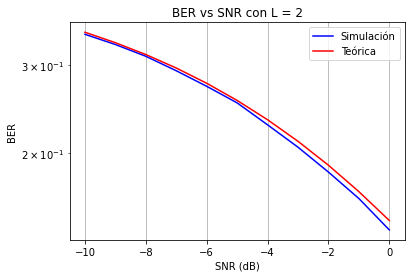

In [49]:
#El móvil receptor se mueva constantemente aprovechando el efecto Doppler para transmitir datos 
#con un esquema BPSK con diversidad temporal, haciendo uso de un codigo de repetición
iteraciones = 150000    #Tomé tres valores distintos
Corrimiento_inicial = iteraciones*2 
Corrimiento_total = 1000000-Corrimiento_inicial          #Centímetros
Corrimiento_step = int((Corrimiento_total - Corrimiento_inicial)/iteraciones)
print("Corrimiento_step: ", Corrimiento_step)            #A que velocidad se mueve el receptor
SNR_dB_max = 0
SNR_dB_min = -10
SNR_dB_step = 1
SNR_dB = np.arange(SNR_dB_min, SNR_dB_max + SNR_dB_step, SNR_dB_step)
SNR = 10 ** (SNR_dB / 10)
Eb = 1  # energia de bit
N0 = Eb / SNR
BER = np.zeros(len(SNR))
L = [1,2,3]                     #Diversidad temporal
a = 1                           #L[1] = 2
h0_canal = canal.ravel()
for k in range(len(SNR)):
    Errores = 0
    iteracion = 0
    for i in range(Corrimiento_inicial,Corrimiento_total+Corrimiento_step,Corrimiento_step):
        iteracion += 1
        offset = np.random.randint(0,Corrimiento_inicial)       #Offset para que no se repitan los bits en las iteraciones
        bit = np.random.randint(0,2,1)
        bit[bit==0] = -1
        simbolo = np.sign(bit)*np.sqrt(Eb)
        
        h0 = np.zeros(L[a], dtype = complex)
        y = np.zeros(L[a], dtype = complex)
        r = np.zeros(L[a], dtype = complex)
        for p in range(L[a]):
            h0[p] = h0_canal[offset + i + int(Corrimiento_step/(L[a])*p)]
            wr = np.random.normal(0, np.sqrt(Eb / (2 * SNR[k])))
            wi = np.random.normal(0, np.sqrt(Eb / (2 * SNR[k])))
            w = wr + 1j*wi
        r = np.real(np.sqrt(np.abs(h0[0])**2+np.abs(h0[1])**2)*simbolo + wr)

        if r < 0:
            x_estimado = -1
        elif r > 0:
            x_estimado = 1
        
        if x_estimado != simbolo:
            Errores += 1
    BER[k] = Errores / iteracion

plt.plot(SNR_dB, BER, 'b')
plt.yscale('log')
plt.xlabel('SNR (dB)')
plt.ylabel('BER')
plt.title('BER vs SNR con L = 2')      
plt.grid()
plt.plot(SNR_dB, Pe(SNR, L[a]), 'r')
plt.legend(['Simulación', 'Teórica'])
plt.show()

Corrimiento_step:  96


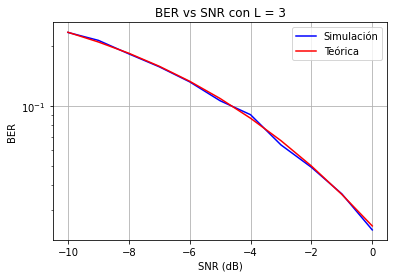

In [39]:
#El móvil receptor se mueva constantemente aprovechando el efecto Doppler para transmitir datos con un esquema BPSK 
#con diversidad temporal, haciendo uso de un codigo de repetición
iteraciones = 10000     #Tomé tres valores distintos
Corrimiento_inicial = iteraciones*2 
Corrimiento_total = 1000000-Corrimiento_inicial          #Centímetros
Corrimiento_step = int((Corrimiento_total - Corrimiento_inicial)/iteraciones)
print("Corrimiento_step: ", Corrimiento_step)            #A que velocidad se mueve el receptor
SNR_dB_max = 0
SNR_dB_min = -10
SNR_dB_step = 1
SNR_dB = np.arange(SNR_dB_min, SNR_dB_max + SNR_dB_step, SNR_dB_step)
SNR = 10 ** (SNR_dB / 10)
Eb = 1  # energia de bit
N0 = Eb / SNR
BER = np.zeros(len(SNR))
L = [1,2,3]                     #Diversidad temporal
a = 2                           #L[2] = 3
h0_canal = canal.ravel()
for k in range(len(SNR)):
    Errores = 0
    iteracion = 0
    for i in range(Corrimiento_inicial,Corrimiento_total+Corrimiento_step,Corrimiento_step):
        iteracion += 1
        offset = np.random.randint(0,Corrimiento_inicial)
        bit = np.random.randint(0,2,1)
        bit[bit==0] = -1
        simbolo = np.sign(bit)*np.sqrt(Eb)
        
        h0 = np.zeros(L[a], dtype = complex)
        y = np.zeros(L[a], dtype = complex)
        r = np.zeros(L[a], dtype = complex)
        for p in range(L[a]):
            h0[p] = h0_canal[offset + i + int(Corrimiento_step/(L[a])*p)]
            wr = np.random.normal(0, np.sqrt(Eb / (2 * SNR[k])))
            wi = np.random.normal(0, np.sqrt(Eb / (2 * SNR[k])))
            w = wr + 1j*wi
        r = np.real(np.sqrt(np.abs(h0[0])**2+np.abs(h0[1])**2+np.abs(h0[2])**2)*simbolo + wr)

        if r < 0:
            x_estimado = -1
        elif r > 0:
            x_estimado = 1
        
        if x_estimado != simbolo:
            Errores += 1
    BER[k] = Errores / iteracion

plt.plot(SNR_dB, BER, 'b')
plt.yscale('log')
plt.xlabel('SNR (dB)')
plt.ylabel('BER')
plt.title('BER vs SNR con L = 3')
plt.grid()
plt.plot(SNR_dB, Pe(SNR, L[a]), 'r')
plt.legend(['Simulación', 'Teórica'])
plt.show()

Text(0, 0.5, 'y [cm]')

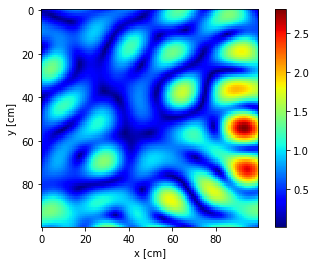

In [24]:
#Heatmap de 100x100 (Zoom)

canalabs = canal[0:100,0:100]
plt.imshow(np.abs(canalabs), cmap='jet', interpolation='nearest')
plt.colorbar()
plt.xlabel('x [cm]')
plt.ylabel('y [cm]')